출처(거의 따라함) => https://github.com/tuengominh/deap-eeg-classification/blob/main/.ipynb_checkpoints/eeg_based_emotion_classification-checkpoint.ipynb

## 1. 데이터 불러오기

In [1]:
import os
from scipy import io
import numpy as np
path = r'C:\Users\100\Desktop\data_preprocessed_matlab/' # 경로는 저장 파일 경로
file_list = os.listdir(path)

for i in file_list:    # 확인
    print(i, end=' ')

s01.mat s02.mat s03.mat s04.mat s05.mat s06.mat s07.mat s08.mat s09.mat s10.mat s11.mat s12.mat s13.mat s14.mat s15.mat s16.mat s17.mat s18.mat s19.mat s20.mat s21.mat s22.mat s23.mat s24.mat s25.mat s26.mat s27.mat s28.mat s29.mat s30.mat s31.mat s32.mat 

In [2]:
mat_file = io.loadmat(path+'s01.mat')

In [3]:
mat_file.keys()

dict_keys(['__header__', '__version__', '__globals__', 'labels', 'data'])

In [4]:
mat_file['data'].shape

(40, 40, 8064)

In [5]:
mat_file['labels'].shape

(40, 4)

In [2]:
k=0

for i in file_list: 
    mat_file = io.loadmat(path+i)
    data = mat_file['data']
    labels = np.array(mat_file['labels'])
    val = labels.T[0].round().astype(np.int8)
    aro = labels.T[1].round().astype(np.int8)
    
    k+=1;
    print(k, end=' ')
    
    if(i=="s01.mat"): 
        Data = data
        VAL = val
        ARO = aro
        continue
        
    Data = np.concatenate((Data ,data),axis=0)   # 밑으로 쌓아서 하나로 만듬
    VAL = np.concatenate((VAL ,val),axis=0)
    ARO = np.concatenate((ARO ,aro),axis=0)

print('finish')

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 finish


In [3]:
type(Data)
type(VAL)

numpy.ndarray

In [4]:
import pandas as pd
pd.DataFrame(VAL).describe()

,0
count,1280.000000
mean,5.235938
std,2.135508
min,1.000000
25%,4.000000
50%,5.000000
75%,7.000000
max,9.000000


In [5]:
pd.DataFrame(ARO).describe()

,0
count,1280.000000
mean,5.136719
std,2.019660
min,1.000000
25%,4.000000
50%,5.000000
75%,7.000000
max,9.000000


In [6]:
pd.DataFrame(ARO).value_counts().sort_index()

1     69
2     78
3    157
4    160
5    194
6    254
7    237
8     93
9     38
dtype: int64

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt  # VAL , ARO 개수 시각화

<AxesSubplot:title={'center':'VALANCE'}, ylabel='count'>

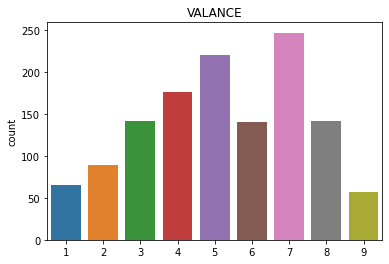

In [8]:
plt.title("VALANCE")
sns.countplot(x=VAL)

<AxesSubplot:title={'center':'AROUSAL'}, ylabel='count'>

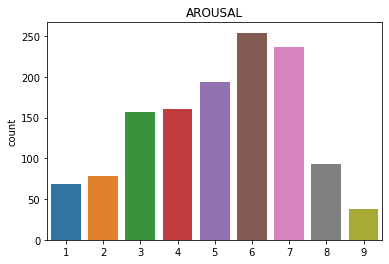

In [9]:
plt.title("AROUSAL")
sns.countplot(x=ARO)

In [10]:
Data.shape

(1280, 40, 8064)

## 2.  데이터 간단한 처리, 확인
- 데이터는 32개의 eeg와 8개의 다른 정보들로 나뉨
- 이를 분류하는 과정

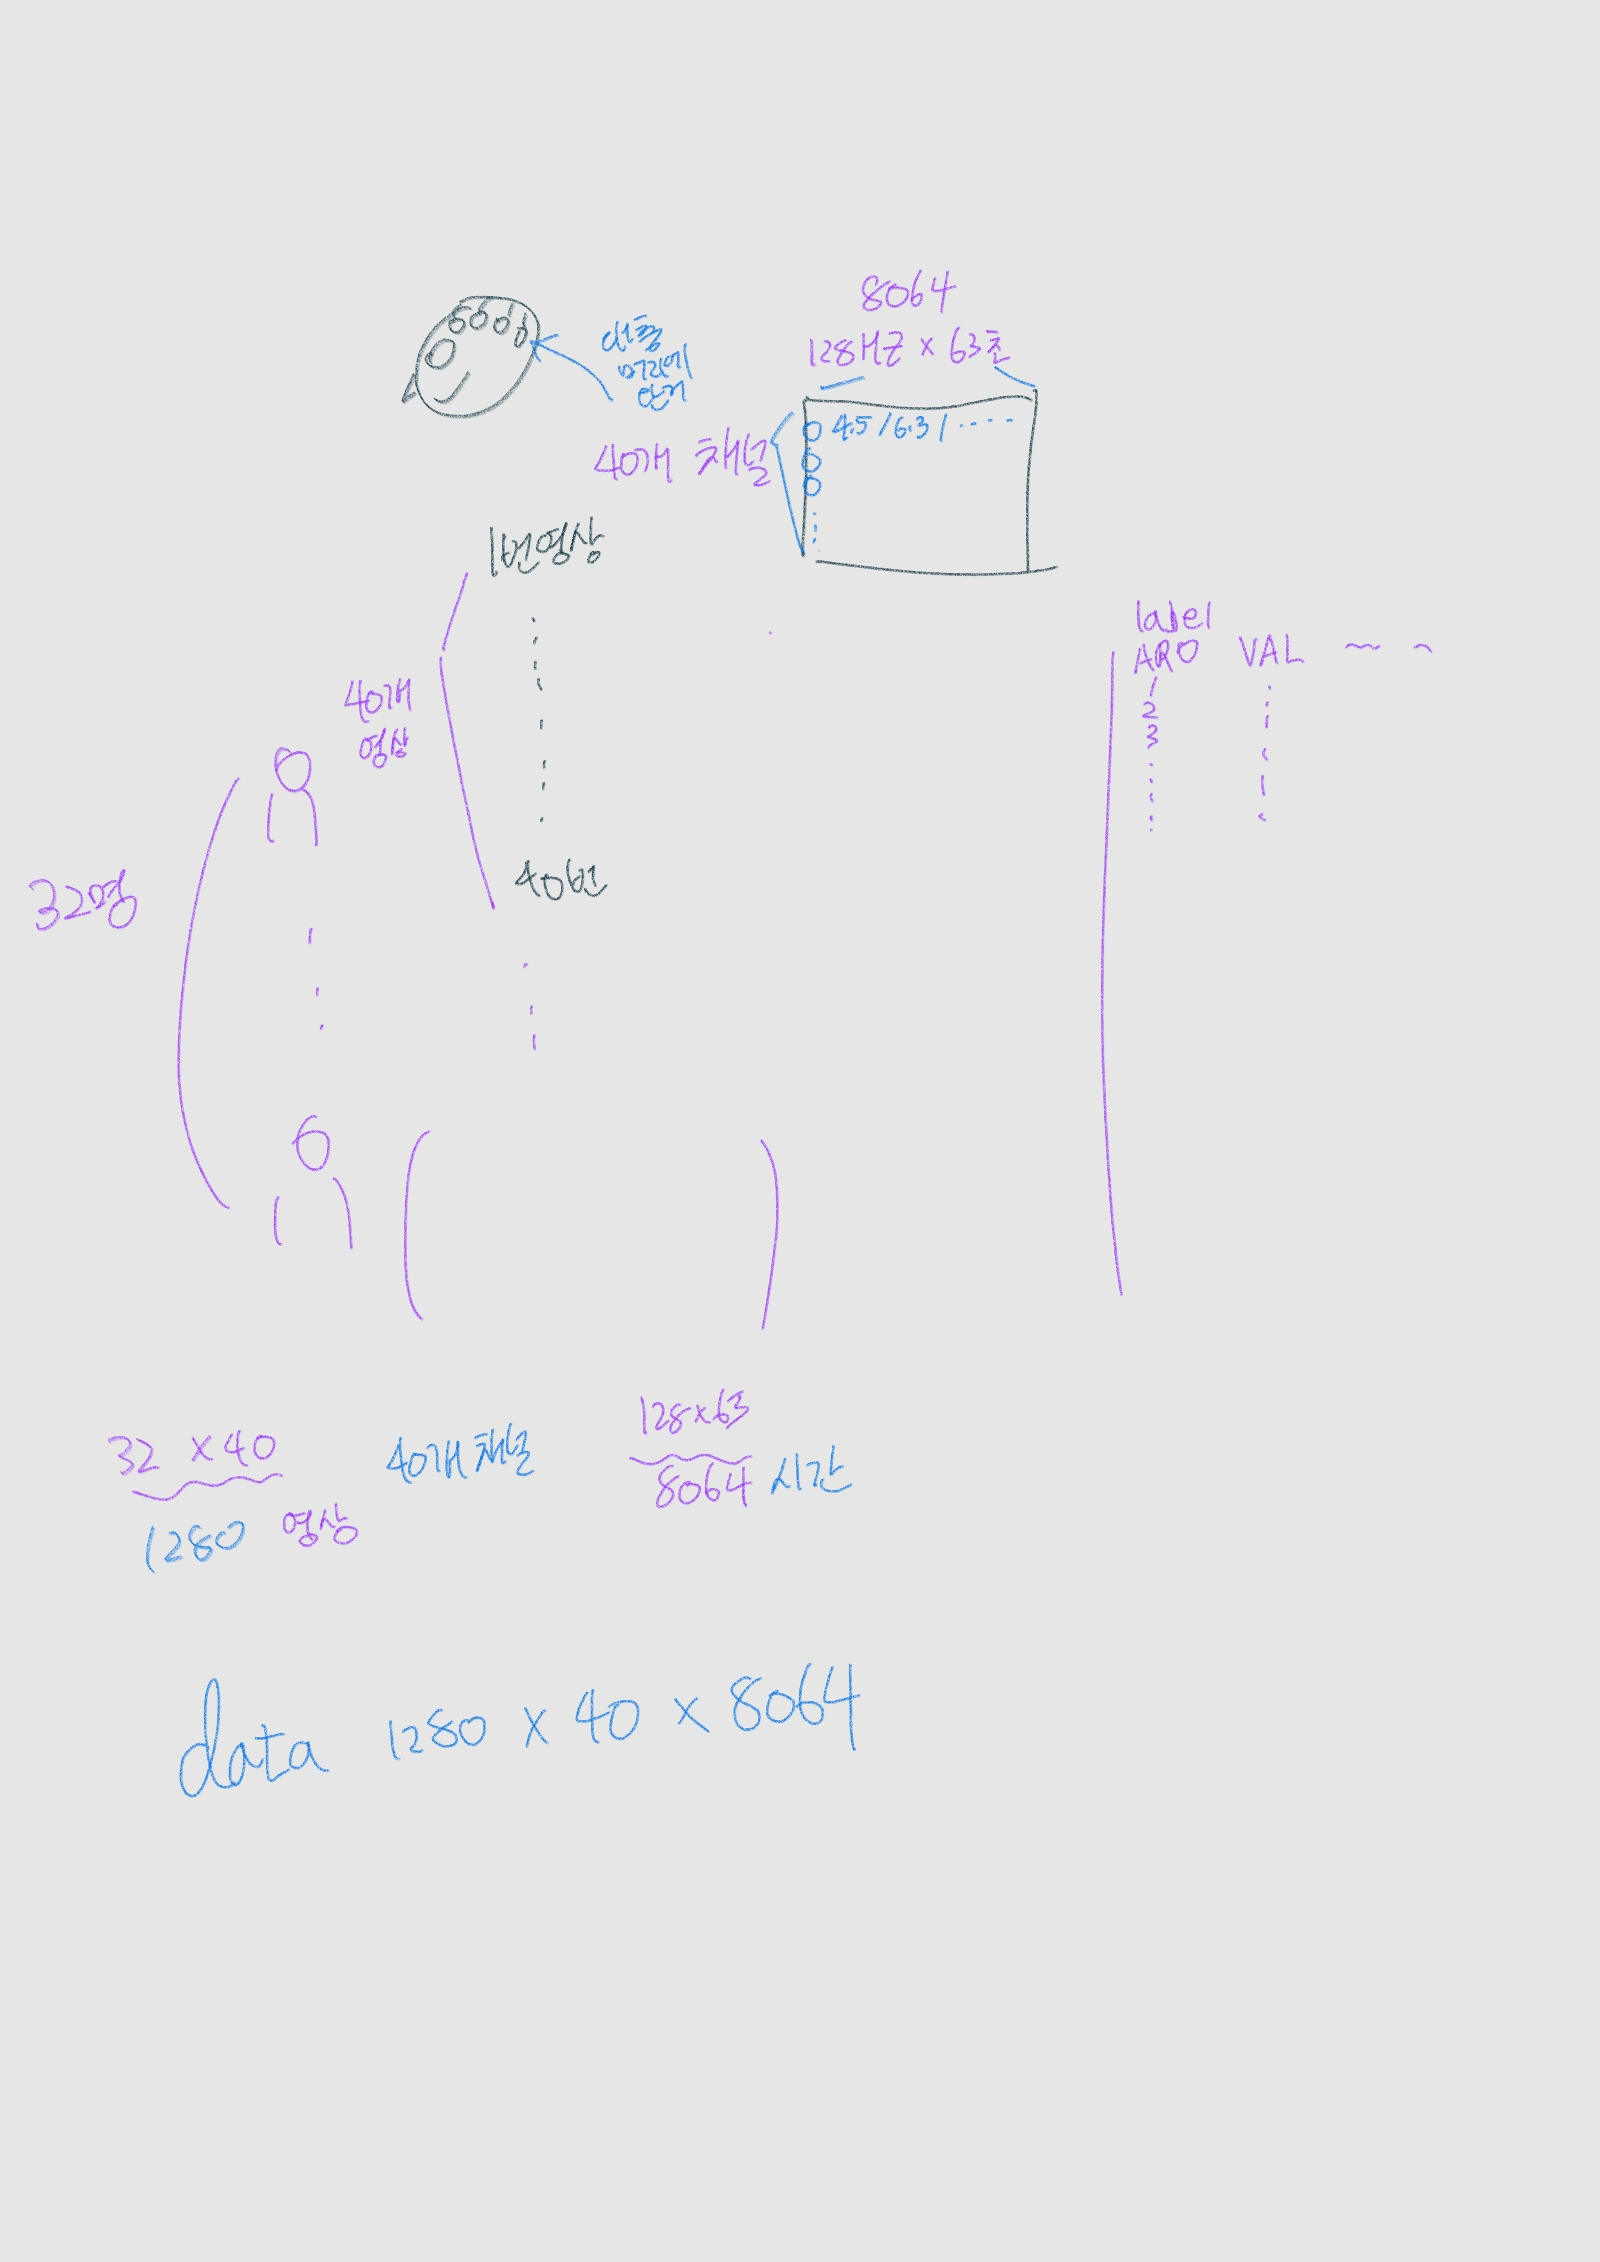

In [11]:
eeg_data = []
peripheral_data = []

for i in range(len(Data)):
    for j in range (40): 
        if(j < 32):
            eeg_data.append(Data[i][j])
        else:
            peripheral_data.append(Data[i][j])

In [12]:
eeg_data = np.reshape(eeg_data, (len(Data),32, 8064))
print(eeg_data.shape)

peripheral_data = np.reshape(peripheral_data, (len(Data),8,8064))
print(peripheral_data.shape)

(1280, 32, 8064)
(1280, 8, 8064)


In [13]:
eeg_data[0][31]

array([0.37227063, 2.07619495, 4.46521875, ..., 2.23958511, 3.18256605,
       4.70807159])

## 데이터 전처리 방법 
1. 데이터 그대로 
2. 변환하여 사용
----

# 3-1. 데이터 그대로

## 01. 데이터 시각화
- 63초 128Hz 다운 샘플됨 => 초당 128번 => 63 * 128 = 8064
- 시간 영역으로 시각화함 

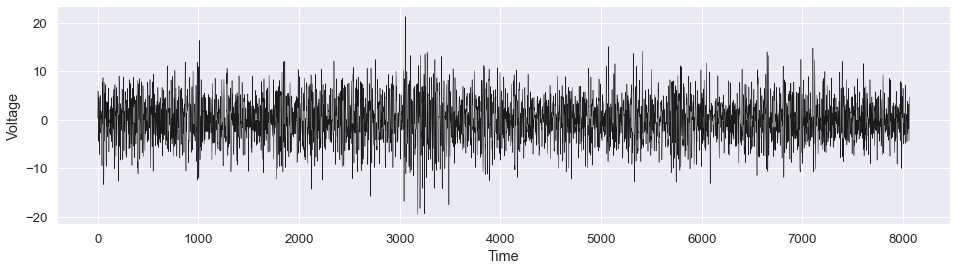

In [14]:
sns.set(font_scale=1.2)

sf = 128.
time = np.arange(eeg_data.size) / sf

fig, ax = plt.subplots(1, 1, figsize=(16, 4))
sns.lineplot(data=eeg_data[0][31], lw=0.5, color='k')  # 0번째 영상의 31채널 데이터
plt.xlabel('Time')
plt.ylabel('Voltage')
sns.despine()
plt.show()

## 02.  머신러닝 - ARO
### 차원 축소

In [15]:
m1_eeg_data = eeg_data.reshape(-1,32*8064)
m1_eeg_data.shape

(1280, 258048)

In [16]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
sc.fit(m1_eeg_data)
sc_m1_eeg_data = sc.transform(m1_eeg_data)

In [17]:
from sklearn.decomposition import PCA
pca_val = PCA(n_components=0.9)
pca_sc_m1_eeg_data = pca_val.fit(sc_m1_eeg_data)

In [18]:
pca_sc_m1_eeg_data.components_.shape

(570, 258048)

In [19]:
pca_sc_m1_eeg_data = pca_sc_m1_eeg_data.transform(sc_m1_eeg_data)

In [20]:
pca_sc_m1_eeg_data.shape

(1280, 570)

### test_train_split

In [21]:
from sklearn.model_selection import train_test_split
test_X, val_X, test_y, val_y = train_test_split(pca_sc_m1_eeg_data, ARO, test_size=0.3) 

### 로지스틱 회귀 - 일대다
- 규제 값을 바꿔가며 학습
    - 규제가 강해지면 주로 6으로 예측한다. 
        - 규제가 약해지면 ( c 값이 증가하면 ) => 훈련 세트에 가능한 최대로 맞추려함
        - 규제가 강해지면 데이터 포인트 중 다수에 맞추려고 하는 방면, 규제가 약해지면 개개의 데이터 포인트를 정확히 분류하려 노력함
            - 출처 :  파이썬 라이브러리를 활용한 머신러닝

In [22]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, precision_score
from sklearn.metrics import classification_report

In [39]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, precision_score
from sklearn.metrics import classification_report
    
arr = [0.01,0.001,0.0001,0.00001,0.000001]
for i in arr:
    print("C=%f 인 모델------------------------------------------------------------" %i)
    Log_model1 = LogisticRegression(max_iter=10000, C=i)
    Log_model1.fit(test_X, test_y)
    print("\n모델의 점수----------------------------------------------------------------------\n")
    print(Log_model1.score(test_X, test_y))
    print(Log_model1.score(val_X, val_y))
    
    print("\n모델의 예측 값의 합--------------------------------------------------------------\n")
    print(pd.DataFrame(Log_model1.predict(val_X)).value_counts())
    
    print("\n혼동 행렬------------------------------------------------------------------------\n")

    cm = confusion_matrix(val_y,Log_model1.predict(val_X))
    print(cm)
    
    print("\n클래스별 맞힌 개수---------------------------------------------------------------\n")
    print(cm.diagonal()) 
    
    print("\n클래스 별 샘플 개수--------------------------------------------------------------\n")
    print(cm.sum(axis=1))
    
    print("\n클래스별 맞힌 비율(%)-----------------------------------------------------------\n")
    print(cm.diagonal() / cm.sum(axis=1) * 100)
    
    print("\n모델의classification_report ----------------------------------------------------\n")
   
    print(classification_report(val_y,Log_model1.predict(val_X)))
    print()
    print("\n==============================================\n")

C=0.010000 인 모델------------------------------------------------------------

모델의 점수----------------------------------------------------------------------

0.9676339285714286
0.1640625

모델의 예측 값의 합--------------------------------------------------------------

7    93
5    66
6    66
3    51
4    51
2    21
1    19
8    16
9     1
dtype: int64

혼동 행렬------------------------------------------------------------------------

[[ 1  0  3  1  2  4  7  0  0]
 [ 0  2  2  2  0  2  8  3  0]
 [ 1  3  4  7  9  8 10  2  0]
 [ 5  2  7  6  8  8  8  1  0]
 [ 3  3 10  8 15  8 17  1  0]
 [ 3  4 10 11 18 17 18  2  0]
 [ 5  4  8 11  7 11 18  4  1]
 [ 1  3  4  4  5  4  6  0  0]
 [ 0  0  3  1  2  4  1  3  0]]

클래스별 맞힌 개수---------------------------------------------------------------

[ 1  2  4  6 15 17 18  0  0]

클래스 별 샘플 개수--------------------------------------------------------------

[18 19 44 45 65 83 69 27 14]

클래스별 맞힌 비율(%)-----------------------------------------------------------

[ 5.55555556 10.526

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



모델의 점수----------------------------------------------------------------------

0.5613839285714286
0.1875

모델의 예측 값의 합--------------------------------------------------------------

6    195
7    174
5      8
4      4
3      3
dtype: int64

혼동 행렬------------------------------------------------------------------------

[[ 0  0  0  0  0  9  9  0  0]
 [ 0  0  0  0  0  9 10  0  0]
 [ 0  0  0  0  1 23 20  0  0]
 [ 0  0  0  2  4 23 16  0  0]
 [ 0  0  0  0  1 35 29  0  0]
 [ 0  0  1  0  2 40 40  0  0]
 [ 0  0  1  2  0 37 29  0  0]
 [ 0  0  1  0  0 11 15  0  0]
 [ 0  0  0  0  0  8  6  0  0]]

클래스별 맞힌 개수---------------------------------------------------------------

[ 0  0  0  2  1 40 29  0  0]

클래스 별 샘플 개수--------------------------------------------------------------

[18 19 44 45 65 83 69 27 14]

클래스별 맞힌 비율(%)-----------------------------------------------------------

[ 0.          0.          0.          4.44444444  1.53846154 48.19277108
 42.02898551  0.          0.        ]

모델의classifica

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



모델의 점수----------------------------------------------------------------------

0.36607142857142855
0.19270833333333334

모델의 예측 값의 합--------------------------------------------------------------

6    291
7     93
dtype: int64

혼동 행렬------------------------------------------------------------------------

[[ 0  0  0  0  0 16  2  0  0]
 [ 0  0  0  0  0 15  4  0  0]
 [ 0  0  0  0  0 32 12  0  0]
 [ 0  0  0  0  0 36  9  0  0]
 [ 0  0  0  0  0 50 15  0  0]
 [ 0  0  0  0  0 59 24  0  0]
 [ 0  0  0  0  0 54 15  0  0]
 [ 0  0  0  0  0 18  9  0  0]
 [ 0  0  0  0  0 11  3  0  0]]

클래스별 맞힌 개수---------------------------------------------------------------

[ 0  0  0  0  0 59 15  0  0]

클래스 별 샘플 개수--------------------------------------------------------------

[18 19 44 45 65 83 69 27 14]

클래스별 맞힌 비율(%)-----------------------------------------------------------

[ 0.          0.          0.          0.          0.         71.08433735
 21.73913043  0.          0.        ]

모델의classification_report -

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


- 아마 AROUSAL의 데이터 중 라벨이 6인 데이터가 가장 많기 때문인 것 같다.  

### 모델 하나 정해서 분석
- C=0.001 모델 설정

In [42]:
from sklearn.linear_model import LogisticRegression
Log_model1 = LogisticRegression(max_iter=10000, C=0.001)
Log_model1.fit(test_X, test_y)

LogisticRegression(C=0.001, max_iter=10000)

In [43]:
print(Log_model1.score(test_X, test_y))
print(Log_model1.score(val_X, val_y))

0.8258928571428571
0.17708333333333334


In [45]:
pd.DataFrame(Log_model1.predict(val_X)).value_counts().sort_index()

1     10
2     12
3     49
4     43
5     68
6     81
7    110
8      9
9      2
dtype: int64

In [46]:
pd.DataFrame(val_y).value_counts().sort_index()

1    18
2    19
3    44
4    45
5    65
6    83
7    69
8    27
9    14
dtype: int64

### 혼동행렬

In [47]:
from sklearn.metrics import confusion_matrix, precision_score

cm = confusion_matrix(val_y,Log_model1.predict(val_X))

[[ 1  0  1  1  3  6  6  0  0]
 [ 0  0  4  2  1  2  8  2  0]
 [ 1  2  4  5 11 10 11  0  0]
 [ 2  2  6  7  8  8 12  0  0]
 [ 1  2  8  5 12 14 19  3  1]
 [ 1  2 13  7 19 20 20  1  0]
 [ 2  2  6 10  9 14 24  1  1]
 [ 2  1  4  5  4  5  6  0  0]
 [ 0  1  3  1  1  2  4  2  0]]


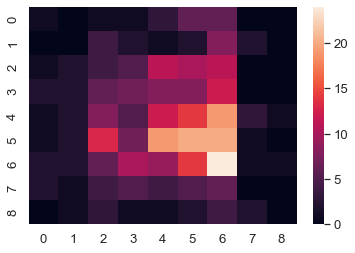

In [48]:
sns.heatmap(cm)
print(cm)

In [49]:
cm.diagonal()

array([ 1,  0,  4,  7, 12, 20, 24,  0,  0], dtype=int64)

In [50]:
cm.sum(axis=1)

array([18, 19, 44, 45, 65, 83, 69, 27, 14], dtype=int64)

- 각 클래스별 맞힌 비율 = 각 클래스별 맞힌 개수 / 각 클래스별 샘플 개수

In [51]:
print(cm.diagonal() / cm.sum(axis=1))

[0.05555556 0.         0.09090909 0.15555556 0.18461538 0.24096386
 0.34782609 0.         0.        ]


### classification_report
- 정밀도
    - 양성으로 예측된 것 중 얼마나 많은 샘플이 진짜 양성인가<br><br>
  
- 재현율
    - 양성 샘플 중에서 얼마나 많은 샘플이 양성 클래스로 분류되는지 측정

In [52]:
print(classification_report(val_y, Log_model1.predict(val_X)))

              precision    recall  f1-score   support

           1       0.10      0.06      0.07        18
           2       0.00      0.00      0.00        19
           3       0.08      0.09      0.09        44
           4       0.16      0.16      0.16        45
           5       0.18      0.18      0.18        65
           6       0.25      0.24      0.24        83
           7       0.22      0.35      0.27        69
           8       0.00      0.00      0.00        27
           9       0.00      0.00      0.00        14

    accuracy                           0.18       384
   macro avg       0.11      0.12      0.11       384
weighted avg       0.16      0.18      0.16       384



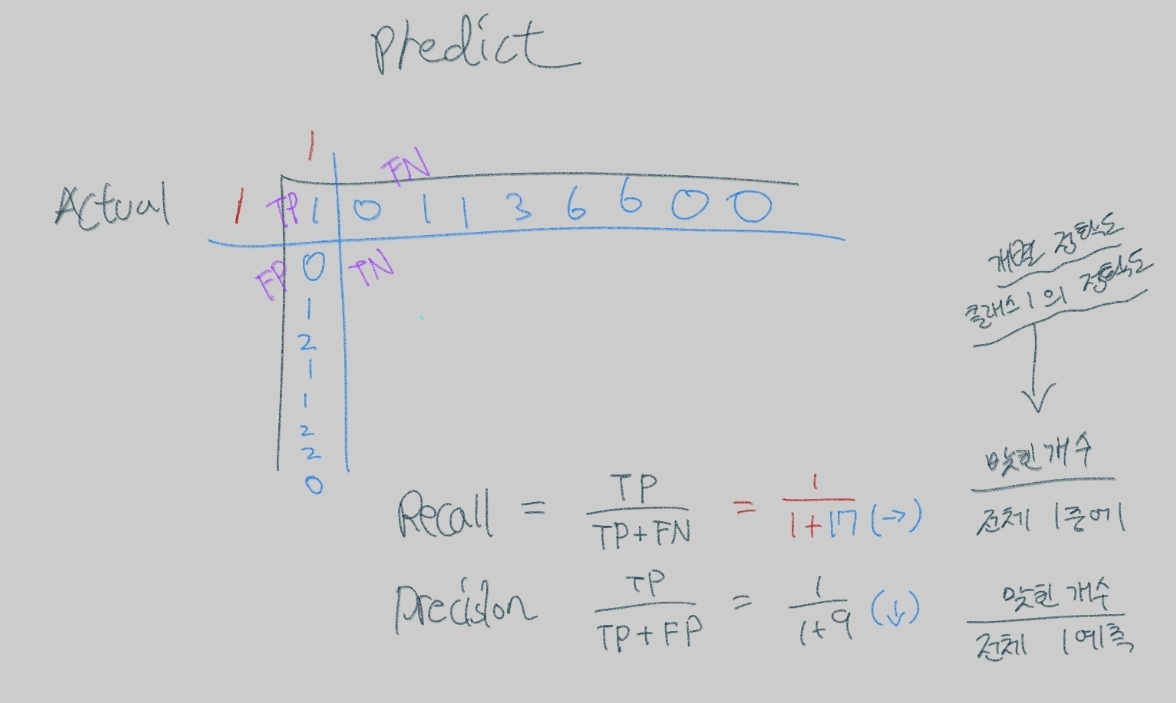

### 로지스틱 회귀 - soft max

In [56]:
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LogisticRegression

Log_model2 = LogisticRegression(max_iter=800)
scores = cross_validate(Log_model2, pca_sc_m1_eeg_data, ARO, return_train_score=True)

In [57]:
scores

{'fit_time': array([1.42047715, 1.48433256, 1.4029665 , 1.07038188, 1.58820963]),
 'score_time': array([0.        , 0.00099778, 0.        , 0.        , 0.        ]),
 'test_score': array([0.1484375 , 0.125     , 0.1328125 , 0.12109375, 0.09375   ]),
 'train_score': array([1., 1., 1., 1., 1.])}

### 결론
- 우선 데이터가 편향되어 있어 모델이 그냥 많은 클래스로 예측을 해버린다. 
    - 즉 편향된 모델이 만들어진다. 
- 데이터에 노이즈가 많아 무엇인가 전처리를 하고 사용해야될 것 같다. 

# 4-1. 데이터 변환
## 데이터 주파수 영역 시각화

- welch method 이용하여 시간 영역의 데이터를 주파수 영역으로 변환
    - https://en.wikipedia.org/wiki/Welch's_method
    - https://www.youtube.com/watch?v=YK1F0-3VvQI
    - FFT 보다 스무스하고 노이즈에 둔감 , 비 정상 데이터에 로버스트하다 
    - 밑의 win은 윈도우의 길이 , 윈도우 함수의 디폴트는 hann ( welch 를 진행할때 사용되는 함수 | 위 영상에 나옴 )
  
        
    
- 알파 베타 감마 세타 4개로 분류 

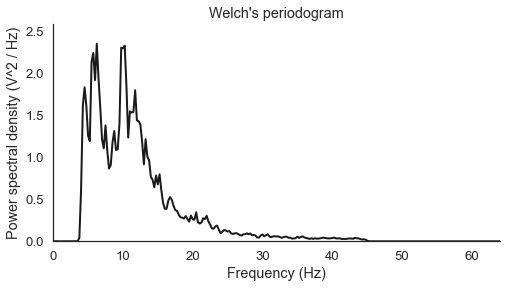

In [53]:
from scipy import signal
from scipy.signal import welch
from scipy.integrate import simps
from scipy.stats import f_oneway

# Define window length (4 seconds)
win = 4 * sf
freqs, psd = signal.welch(eeg_data[0,31], sf, nperseg=win) # welch 변환

# Plot the power spectrum
sns.set(font_scale=1.2, style='white')
plt.figure(figsize=(8, 4))

plt.plot(freqs, psd, color='k', lw=2)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power spectral density (V^2 / Hz)')
plt.ylim([0, psd.max() * 1.1])
plt.title("Welch's periodogram")
plt.xlim([0, freqs.max()])
sns.despine()

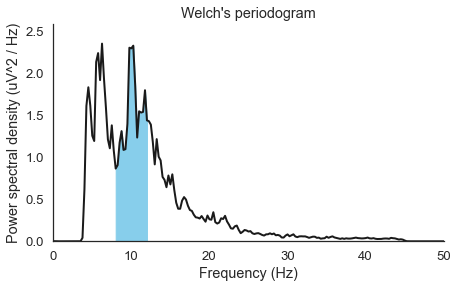

In [54]:
# Define alpha lower and upper limits
low, high = 8, 12

# Find intersecting values in frequency vector
idx_alpha = np.logical_and(freqs >= low, freqs <= high)

# Plot the power spectral density and fill the alpha area
plt.figure(figsize=(7, 4))
plt.plot(freqs, psd, lw=2, color='k')
plt.fill_between(freqs, psd, where=idx_alpha, color='skyblue')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power spectral density (uV^2 / Hz)')
plt.xlim([0, 50])
plt.ylim([0, psd.max() * 1.1])
plt.title("Welch's periodogram")

sns.despine()


## 주파수의 크기 값(뇌파의 크기) 구해주는 함수
- 심프슨 공식을 이용해서 적분 근사값을 구함
    - https://ko.wikipedia.org/wiki/%EC%8B%AC%ED%94%84%EC%8A%A8_%EA%B3%B5%EC%8B%9D
    - https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.integrate.simps.html

In [55]:
def bandPower(data, sf, band, window_sec=None, relative=False):
    band = np.asarray(band)
    low, high = band
    
    if window_sec is not None:
        nperseg = window_sec * sf
    else:
        nperseg = (2/low) * 128
        
    freqs, psd = welch(data, sf, nperseg=nperseg)
    
    freq_res = freqs[1]-freqs[0] # 주파수 해상도 
    #print(freqs)
    #print(freq_res)
    
    idx_band = np.logical_and(freqs >= low, freqs <= high)  # 영역 설정 ( 알파 베타 ... )
    bp = simps(psd[idx_band], dx=freq_res)
    
    if relative:  # 표준화된 값 구하고 싶을 때 사용
        bp /= simps(psd, dx=freq_res)
    return bp

def get_band_power(trial, channel, band):
    bd = (0,0)
    
    if(band == "theta"):
        bd = (4,8)
    elif (band=="alpha"):
        bd = (8,12)
    elif (band == "beta"):
        bd = (12,30)
    elif (band == "gamma"):
        bd = (30,64)
        
    return bandPower(eeg_data[trial][channel], 128, bd)

print(get_band_power(0,31,"theta"))
print(get_band_power(0,31,"alpha"))
print(get_band_power(0,31,"beta"))
print(get_band_power(0,31,"gamma"))

5.434119660168186
5.369595513295194
6.286556266834863
0.9879159580139809


### 모든 시간 데이터를 (알파, 베타, 감마,세타) 크기 값으로 바꾸기
- 지금은 세타 값만 빼서 사용

In [56]:
eeg_band = []
for i in range (len(eeg_data)):
    for j in range(len(eeg_data[0])):
        eeg_band.append(get_band_power(i,j,"theta"))
        eeg_band.append(get_band_power(i,j,"alpha"))
        eeg_band.append(get_band_power(i,j,"beta"))
        eeg_band.append(get_band_power(i,j,"gamma"))
        
eeg_band = np.reshape(eeg_band, (1280,32,4))
eeg_theta = []
eeg_theta = eeg_band[:,:,0]

In [ ]:
pd.DataFrame(eeg_band).to_csv("band.csv")

In [57]:
eeg_channels = np.array(["Fp1", "AF3", "F3", "F7", "FC5", "FC1", "C3", "T7", "CP5", "CP1", "P3", "P7", "PO3", "O1", "Oz", "Pz", "Fp2", "AF4", "Fz", "F4", "F8", "FC6", "FC2", "Cz", "C4", "T8", "CP6", "CP2", "P4", "P8", "PO4", "O2"])
df_theta = pd.DataFrame(eeg_theta,columns=eeg_channels)

In [58]:
df_theta.describe()

,Fp1,AF3,F3,F7,FC5,FC1,C3,T7,CP5,CP1,...,FC2,Cz,C4,T8,CP6,CP2,P4,P8,PO4,O2
count,1280.000000,1280.000000,1280.000000,1280.000000,1280.000000,1280.000000,1280.000000,1280.000000,1280.000000,1280.000000,...,1280.000000,1280.000000,1280.000000,1280.000000,1280.000000,1280.000000,1280.000000,1280.000000,1280.000000,1280.000000
mean,517.431002,974.493856,795.093910,1515.004071,746.435950,345.936665,486.095113,354.004358,664.656754,276.667812,...,669.953166,518.975872,471.905917,763.990397,544.785103,303.158814,527.491149,222.759444,780.700914,327.242856
std,1165.295163,3147.555132,3020.711666,4990.544508,2188.101734,717.328768,1497.636647,641.432373,2146.857585,498.823733,...,1714.340609,1407.210210,1896.584105,2236.655420,1563.878765,650.093432,1429.084909,451.119818,1802.083002,1080.707954
min,2.698928,1.995398,1.820656,3.283107,1.311200,2.025214,1.200156,3.418167,1.857737,1.340340,...,2.809501,1.637028,1.713283,2.133474,1.496299,1.439077,1.791296,1.641482,1.995230,3.681268
25%,23.306027,17.117475,18.392335,30.827191,14.023436,17.383454,18.273844,43.838157,19.178089,28.281757,...,14.927239,23.440039,9.724978,25.143155,18.202863,26.754006,18.110041,18.064264,23.491991,19.333926
50%,65.468048,82.102529,60.241953,91.266539,48.704968,55.561232,46.451432,128.629588,61.998792,60.330974,...,66.078472,67.044674,24.318235,90.110040,77.517763,88.083088,62.269206,90.914662,69.772647,49.630345
75%,331.636624,304.949248,175.394835,248.308696,218.358248,281.828747,234.342275,348.249862,312.653366,237.040645,...,214.293557,305.766182,109.715681,386.232875,297.742897,257.959593,246.195582,225.463786,495.202699,113.117403
max,15524.135098,38122.870846,39431.320394,49272.793208,20182.668545,8542.244175,26021.167025,7023.985761,23255.512271,5972.589469,...,18617.218099,16408.471958,24826.365142,28038.714329,19908.437378,7210.746793,17568.065100,5487.311705,17167.017710,12314.030522


In [59]:
df_theta.shape

(1280, 32)

In [60]:
type(ARO)

numpy.ndarray

In [61]:
ARO=ARO.reshape(-1,1)
ARO.shape

(1280, 1)

### 머신러닝

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier


#생각보다 효과가.... 조금 더 공부하고 적어야겠다 ...

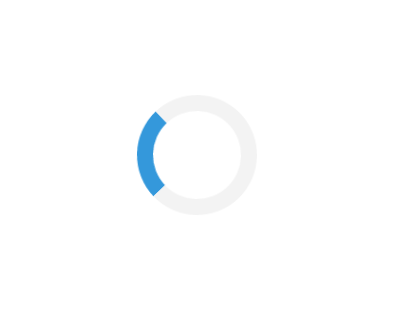

### 신경망

In [ ]:
# 컨셉